# ENRON POI Detection Project Peter Bakke


#### 1a. Background on the dataset and how it can be used to answer the project goal.

ENRON was a large U.S. corporation which was convicted of accounting fraud in the last 1990's, early 2000's. When the case was closed in 2001, a very large number of emails became publicly available for academic purposes (Note 1). The question of who might be a POI is investigated using various machine learning techniques described below.

#### 1b. Summary of the goal of this project and how machine learning is useful in trying to accomplish it.

In this project, preprocessed information about ENRON Corporation emails is used to identify potential persons of interest (POI) related to the fraud case brought against the ENRON corporation. In other words, we have been provided a derivative datatset with aggregate information (features) about the original data. Doing so negates the need to process tens of thousands of individual emails. Rather, information about each person's email characteristics, such as the aggregate numbers of senders, CCs, replies, etc. have been provided by researchers. In addition, financial data such as salary and bonuses have been added to the data (per person), as well. See the email features list below. A list of suspected POIs has also been provided as apriori data to check the accuracy of models. These apriori POIs were identified using newspaper research into those who were convicted or indicted for fraud, conspiracy, etc.(Note 4).

Machine learning's (ML) ability to perform computational pattern recognition is well-suited for the task of identifying POIs. The ENRON email corpus consists of tens of thousands of emails and their inherent relationships to POIs. ML's ability to efficiently sort through and ID potential POIs in a relatively short amount of time has great value. Once tuned, similar ML techniques could be used for other ML problems, as well. Of course, any machine learning results that impact human lives should always be verified in additional ways.

#### Note: I want to make something clear to first time readers of the ENRON machine learning project.

We are not directly using the raw ENRON data (tens of thousands of emails) in this particular project. Instead, we are using a dataset that summarizes the ENRON data per person. It's almost like we are using ENRON corpus metadata, that is, data about the data.

There are 146 entries in the starting ENRON email and financial summary dataset before cleaning and each has 21 features ranging from number of emails sent by the individual to their salary. Of the entries in the summary ENRON dataset, we have only 18 out of 35 identified persons of interest (POIs) that we can use to train our various models (Note 4). POIs were identified using newspaper archival research. I call this list "apriori" POIs, meaning that they are known prior to training and testing the ML models. POIs are identified in the dataset with a 'poi' flag set to 'True' (='1').

We are tasked in this project to identify POIs with a minimum recall and precision of at least .30. That score does not sound very hard to attain until we realize the small amount of data we are working with which gets even smaller when we break the data into training and testing datasets.

For example, If we split the summary email and financial dataset into training and testing subsets of 70% and 30%, respectively, we end up with a TRAINING dataset of 102 entries having approximately 13 POIs (.70 test size * 18 POIs). Subsequently, we are tasked to identify the remaining 5 POIs in the TEST set which contains 44 entries. The low recall and precision of .3 is permitted in this situation because the training/testing (combined with few POIs) is so small.

#### I originally thought we were going to identify new POIs based on machine learning. But, no, we are simply trying to correctly ID known apriori POIs in the TEST set using features of the TRAINING set.

With the reader's permission, I'll take a moment to illustrate the underlying structure of this project. For illustrative purposes, I'll use a 20-entry mini-ENRON dataset containing 8 POIs (where POI labels set to TRUE ['1' equals a POI]).

[0,1,0,1,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0] ...the sum of POIS = 8

If we break this original datatset of labels randomly into a training set of 14 entries (70%) and a test set of 6 entries (30%), there ought to be about 6 POIs (.7 8) in the TRAINING set and 2 (.3 8) POIs in the TEST set like so:

Training labels = [0,1,0,1,1,1,0,0,1,0,0,1,0,0] ...sum of POIS = 6 Testing labels = [1,0,0,0,1,0] ...sum of POIs = 2

We can then use ML modeling techniques to evaluate the 21 FEATURES (or a subset, thereof) of the known 6 POIs in the TRAINING set to create a model that distinguishes POIs from non-POIs.

Once we have tuned the TRAINING model, we run the model against the TEST set features to create a prediction. If the model has 100% accuracy, the resulting six entry prediction labels would look like this:

Model Prediction = [1,0,0,0,1,0] ...which exactly matches the TEST set above.

But in reality, the model will likely not have 100% accuracy and may return false negatives and false postitives. Two false negatives might look like this:

Model Prediction = [0,0,0,0,0,0] ...That is, there are 2 POIs in the TEST set [1,0,0,0,1,0], but none were predicted.

and a false positive might look like this:

Model Prediction = [0,0,1,0,0,0] ...One POI was predicted, but it is incorrect.

Whereas, the following model prediction has an accuracy (loosely defined) of 50%.

Model Prediction = [1,0,0,0,0,0] ... it predicted 1 out of 2 POIs correctly and had no false positives, but had one false negative)

FYI, the Confusion Matrix supplies a concise report of a prediction's true positives, false positives, false negatives and true negatives (see Note 10).


#### Import Python libraries and load the data. Note: On my local Windows 10 machine, I added system paths to all programs and data, therefore, this Jupyter notebook has no need for relative OS addressing, although it is set up to still work with relative addressing for compatability.

In [1]:
import locale
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import sys
import pickle
from sklearn import preprocessing
#from sklearn.preprocessing import MinMaxScaler
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.svm import SVC
import pandas as pd
import math
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.patches as mpatches
from sklearn.feature_selection import SelectKBest, f_classif
from feature_format import featureFormat
from feature_format import targetFeatureSplit
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from tester import dump_classifier_and_data
from copy import deepcopy

sys.path.append("../tools/")


### load the 2-level data dictionary. Level 1 = Person, Level 2 = Features described below. 
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

# Save a copy of the original dataset for debug purposes
data_dict2 = data_dict.copy()  # Do it this way otherwise if set a = b, then when either one is changed, both change.


C:\Users\peter\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\peter\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Explore the ENRON email and financial data dictionary:

In [2]:
print "The dictionary keys are the names of ENRON executives :"
print "(There are actually two non-persons embedded in the data that will be cleaned later. See note 6).  \n\n", data_dict.keys()

The dictionary keys are the names of ENRON executives :
(There are actually two non-persons embedded in the data that will be cleaned later. See note 6).  

['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'D

#### How many initial features are there per person (key) and what are they?

In [3]:
print "Here is a list of initial features per person (each person is a dictionary key)\n\n" 

feat_count = 1
for key, value in data_dict['METTS MARK'].iteritems() :
    print feat_count, key
    feat_count += 1

feat_count -= 1
print "\nThere are ", feat_count , "features for every person in the dataset \n\n"

Here is a list of initial features per person (each person is a dictionary key)


1 salary
2 to_messages
3 deferral_payments
4 total_payments
5 exercised_stock_options
6 bonus
7 restricted_stock
8 shared_receipt_with_poi
9 restricted_stock_deferred
10 total_stock_value
11 expenses
12 loan_advances
13 from_messages
14 other
15 from_this_person_to_poi
16 poi
17 director_fees
18 deferred_income
19 long_term_incentive
20 email_address
21 from_poi_to_this_person

There are  21 features for every person in the dataset 




#### Before we proceed, data exploration uncovered two keys that are not persons. The key 'TOTAL' was imported from an excel sheet. We will delete it because it creates outliers for all numerical features. 
#### You can see an example of how 'TOTAL' skews features by looking at a visual display of 'salary' vs 'bonus' and how 'TOTAL' creates an outlier :

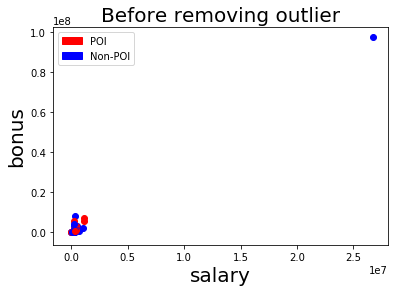

In [4]:
features1 = ["salary", "bonus", "poi"]
data = featureFormat(data_dict2, features1)

for point in data:
    salary = point[0]
    bonus = point[1]
    if point[2] == 1:
        plt.scatter( salary, bonus, color = 'red' )
    else:
        plt.scatter( salary, bonus, color = 'blue' )

plt.xlabel("salary",fontsize=20)
plt.ylabel("bonus",fontsize=20)
plt.title("Before removing outlier",fontsize=20)
red_patch = mpatches.Patch(color='red', label='POI')
blue_patch = mpatches.Patch(color='blue', label='Non-POI')
plt.legend(handles=[red_patch, blue_patch])

plt.show()

The following 'TOTAL' values will be removed from the dataset. This will remove clear-cut outliers for all numeric features.

'TOTAL': {'bonus': 97343619,
  'deferral_payments': 32083396,
  'deferred_income': -27992891,
  'director_fees': 1398517,
  'email_address': 'NaN',
  'exercised_stock_options': 311764000,
  'expenses': 5235198,
  'from_messages': 'NaN',
  'from_poi_to_this_person': 'NaN',
  'from_this_person_to_poi': 'NaN',
  'loan_advances': 83925000,
  'long_term_incentive': 48521928,
  'other': 42667589,
  'poi': False,
  'restricted_stock': 130322299,
  'restricted_stock_deferred': -7576788,
  'salary': 26704229,
  'shared_receipt_with_poi': 'NaN',
  'to_messages': 'NaN',
  'total_payments': 309886585,
  'total_stock_value': 434509511}

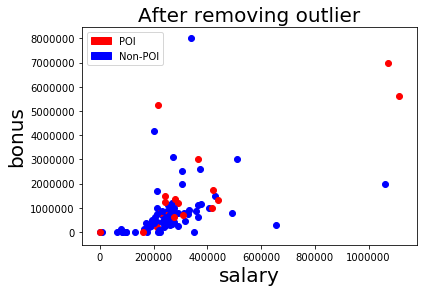

In [5]:
### Remove the 'TOTAL' key and values and replot

data_dict.pop('TOTAL',0)

# Replot to demonstrate removal of outlier

data = featureFormat(data_dict, features1)

for point in data:
    salary = point[0]
    bonus = point[1]
    if point[2] == 1:
        plt.scatter( salary, bonus, color = 'red' )
    else:
        plt.scatter( salary, bonus, color = 'blue' )

plt.xlabel("salary",fontsize=20)
plt.ylabel("bonus",fontsize=20)
plt.title("After removing outlier",fontsize=20)
red_patch = mpatches.Patch(color='red', label='POI')
blue_patch = mpatches.Patch(color='blue', label='Non-POI')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

#### Visual inspection caught another non-person in the dataset : Remove 'THE TRAVEL AGENCY IN THE PARK'

In [6]:
# We want to have a clean dataset before we do furhter inspection and modeling
data_dict.pop('THE TRAVEL AGENCY IN THE PARK',0)
print

#### Lastly, I also discovered a person ('LOCKHART EUGENE E') who has no data whatsoever, so I'm removing that person as well:

In [7]:
# I also discovered a person ('LOCKHART EUGENE E') who has no data whatsoever, so I'm removing that person as well: 
data_dict.pop('LOCKHART EUGENE E',0)
print

#### How many people are in the final data set?

In [8]:
num_people = len(data_dict.keys())
print "\nThere are ", num_people , " people in the email and financial dataset (each key is a person's name)."



There are  143  people in the email and financial dataset (each key is a person's name).


#### Let's look at a summary of salaries received by employees. This shows us the magnitude of the money involved and is of general interest, as well.

In [9]:
# prepare printing currency. See Note 2.
locale.setlocale(locale.LC_ALL,"")
currency_symbol = locale.localeconv()['currency_symbol']

salaries = list()
salaries_poi = list()
for key1, value1 in data_dict.iteritems() :
    for key2, value2 in data_dict[key1].iteritems() :
        if key2 == 'salary' :
            if value2 != 'NaN' :
                salaries.append(value2)
        elif key2 == 'poi' and value2 == True :
            salaries_poi.append(key1)

salaries = sorted(salaries)
salaries_poi = sorted(salaries_poi)

print "\nOut of the total", num_people, " people, the number who had recorded salaries was ", len(salaries)
print "Of", len(salaries), "people who had recorded salaries", len(salaries_poi), "were POIs." 
#print ("Bonuses cleaned", bonuses)

print "\nSalaries Summary:\n"
print "Minimun  \t= \t", currency_symbol + locale.format("%.0f", min(salaries), 1)
print "Maximum  \t= \t", currency_symbol + locale.format("%.0f", max(salaries), 1) 
print "Mean \t\t= \t", currency_symbol + locale.format("%.0f", round(np.mean(salaries),2), 1) 
print "Median  \t= \t", currency_symbol + locale.format("%.0f", round(np.median(salaries),2), 1) 
print "Std. Dev  \t= \t", currency_symbol + locale.format("%.0f", round(np.std(salaries),2), 1) 



Out of the total 143  people, the number who had recorded salaries was  94
Of 94 people who had recorded salaries 18 were POIs.

Salaries Summary:

Minimun  	= 	$477
Maximum  	= 	$1,111,258
Mean 		= 	$284,088
Median  	= 	$258,741
Std. Dev  	= 	$176,186


#### We could look at all 21 features in this manner, but we'll stop here and get on with the project goal: Identify POIs

We were given apriori information about suspected POIs (using newspaper research) and they are marked in the dataset using 'poi' feature =  True = '1'. 

#### How many POIs are there in the dataset and who are they? What total payments did they receive?

In [10]:
apriori_poi = list()
for key1, value in data_dict.iteritems() :
    for key2, value in data_dict[key1].iteritems() :
        if key2 == 'poi' :
            if value == 1 :
                apriori_poi.append(key1)
                #print key1, "\n\tTotal Payments \t= \t", currency_symbol + locale.format("%.0f", data_dict[key1]['total_payments'], 1)
                

apriori_poi = sorted(apriori_poi)

print "\nThere are", len(apriori_poi), "apriori POIs out of the ", num_people, "people in the dataset.\n "
print "For training purposes, we only have 18 POI data points out of", num_people," people to work with in the dataset."
print "This is a relatively low number to train and test with.\n"

print "Following is a list sorted by name of apriori POIs and their total payments. \n\n"

i = 1
for person in apriori_poi:
    print i, person, "\n\tTotal Payments \t= \t", currency_symbol + locale.format("%.0f", data_dict[person]['total_payments'], 1)
    i += 1



There are 18 apriori POIs out of the  143 people in the dataset.
 
For training purposes, we only have 18 POI data points out of 143  people to work with in the dataset.
This is a relatively low number to train and test with.

Following is a list sorted by name of apriori POIs and their total payments. 


1 BELDEN TIMOTHY N 
	Total Payments 	= 	$5,501,630
2 BOWEN JR RAYMOND M 
	Total Payments 	= 	$2,669,589
3 CALGER CHRISTOPHER F 
	Total Payments 	= 	$1,639,297
4 CAUSEY RICHARD A 
	Total Payments 	= 	$1,868,758
5 COLWELL WESLEY 
	Total Payments 	= 	$1,490,344
6 DELAINEY DAVID W 
	Total Payments 	= 	$4,747,979
7 FASTOW ANDREW S 
	Total Payments 	= 	$2,424,083
8 GLISAN JR BEN F 
	Total Payments 	= 	$1,272,284
9 HANNON KEVIN P 
	Total Payments 	= 	$288,682
10 HIRKO JOSEPH 
	Total Payments 	= 	$91,093
11 KOENIG MARK E 
	Total Payments 	= 	$1,587,421
12 KOPPER MICHAEL J 
	Total Payments 	= 	$2,652,612
13 LAY KENNETH L 
	Total Payments 	= 	$103,559,793
14 RICE KENNETH D 
	Total Payments 	= 

#### Note that in the list above, 'LAY KENNETH L' was founder and Chairman of Enron Corporation and 'SKILLING JEFFREY K' was ENRON CEO. 


##  Feature Selection.
#### I started out using all features for modeling. Then, if the models did not reach the .3 criteria for recall and precision scores, I worked on feature selection using KBest. As opposed to manually trying to find features that have relationships among the 20+ possibilities, I used sklearn's computational algorithms to do so. I chose to use SelectKBest.
#### Note: selecting, say, five features randomly from the 23 (original and new) feature options results in 33,649 possible combinations (Note 8). Thus, the need (in my mind) to use a computational algorithm to select the best features.  
#### Before using SelectKBest to select features, I created 4 new features using intuition. We'll see if they are valuable or not (contribute information) when I do the automatic feature selection.
#### The new features are: frac_to_poi_email, frac_from_poi_email, frac_salary_to_total_pay, frac_bonus_to_total_pay
#### The result is 23 usable features (21 original features + 4 new features - 2 unusable features['POI' and 'email_address']) 




In [11]:
### create 4 new features based on intuition and add to dataset.
### new features are: frac_to_poi_email, frac_from_poi_email, frac_salary_to_total_pay, frac_bonus_to_total_pay

def frac_list(key,normalizer):
    new_list=[]

    for name in data_dict2:
        if data_dict2[name][key]=="NaN" or data_dict2[name][normalizer]=="NaN":
            new_list.append(0.)
        elif data_dict2[name][key]>=0:
            new_list.append(float(data_dict2[name][key])/float(data_dict2[name][normalizer]))
    return new_list

### create lists of new features
frac_from_poi_email = frac_list("from_poi_to_this_person","to_messages")
frac_to_poi_email = frac_list("from_this_person_to_poi","from_messages")
frac_salary_to_total_pay = frac_list("salary","total_payments")
frac_bonus_to_total_pay = frac_list("bonus","total_payments")

### insert the new features into copy of data_dict
count=0
for name in data_dict2:
    data_dict2[name]["frac_from_poi_email"]=frac_from_poi_email[count]
    data_dict2[name]["frac_to_poi_email"]=frac_to_poi_email[count]
    data_dict2[name]["frac_salary_to_total_pay"]=frac_salary_to_total_pay[count]
    data_dict2[name]["frac_bonus_to_total_pay"]=frac_bonus_to_total_pay[count]
    count +=1


In [12]:

#orig_and_new_features = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees', 'frac_to_poi_email', 'frac_from_poi_email', 'frac_salary_to_total_pay', 'frac_bonus_to_total_pay']
orig_and_new_features = ['poi','salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees', 'frac_to_poi_email', 'frac_from_poi_email', 'frac_salary_to_total_pay', 'frac_bonus_to_total_pay']

In [13]:
print "The length of features plus 'poi' = ", len(orig_and_new_features)

The length of features plus 'poi' =  24


#### Numpy arrays for Labels and Featues is created here

In [17]:
#Prepare to do  baseline training. Use all features (original and new) to begin with

data = featureFormat(data_dict, orig_and_new_features, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Save an original version of all features and labels for KBest selection evaluation farther below
features_all = deepcopy(features)  # Do it this way otherwise if set a = b, then when either one is changed, both change
labels_all = deepcopy(labels)  # Do it this way otherwise if set a = b, then when either one is changed, both change
#print  features


#### In the following list of 143 labels (key = persons), there are 18 POIS as seen by the '1's.

In [18]:
print labels
print "\nDouble check that the number of POIs in the data is 18...POIs =", sum(labels)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

Double check that the number of POIs in the data is 18...POIs = 18.0


In [19]:
#print len(features), "..number of feature|label entries in the dataset that have a value for at least one of the features. "
#print "'featureFormat' strips out any entries that have zeroes and NaNs in all the features of an entry. This is good. "
#print "All entries have at least one filled-in feature"

#### Find the  best features using KBest

In [21]:
#print orig_and_new_features
#print "\n\n", features
#print "\n\n", features_all

In [22]:
#########################################
######################################### 

# create an instance of the KBest method:
#kbest = SelectKBest()

#if there are specific options that you want, you can include them in the parentheses:
#i.e. select the best features using 'SelectKBest'  
kbest = SelectKBest(f_classif, k=10)

# fit the method (or in the case of processing the data, fit and transform at the same time).
# selected_features are the features selected by SelectKbest 
selected_features = kbest.fit_transform(features, labels)
# DEBUG
#print selected_features, "\n"


# Create the final features list using KBest info
features_list = [orig_and_new_features[i+1] for i in (kbest.get_support(indices=True))]
# DEBUG
#print features_list
# add 'poi' to start of list
features_list = ['poi'] + features_list
print "\nFinal 'best' features list:\n\n", features_list




Final 'best' features list:

['poi', 'salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'frac_to_poi_email', 'frac_bonus_to_total_pay']


In [23]:
#Debug
print kbest.get_support()

[ True False False  True False  True False  True  True False False  True
 False False False  True False  True False  True False False  True]


In [24]:
print kbest.scores_

[18.28968404  1.64634113  0.22461127  8.77277773  7.18405566 20.79225205
  0.06549965 11.45847658 24.18289868  6.09417331  5.24344971 24.81507973
  0.16970095  4.18747751  2.38261211  9.92218601  8.58942073  9.21281062
  2.1263278  16.40971255  3.12809175  2.68741759 20.71559625]


In [25]:
kbscores = np.array(kbest.scores_) #Create numpy array

In [26]:
kbscores

array([18.28968404,  1.64634113,  0.22461127,  8.77277773,  7.18405566,
       20.79225205,  0.06549965, 11.45847658, 24.18289868,  6.09417331,
        5.24344971, 24.81507973,  0.16970095,  4.18747751,  2.38261211,
        9.92218601,  8.58942073,  9.21281062,  2.1263278 , 16.40971255,
        3.12809175,  2.68741759, 20.71559625])

#### Print KBest scores and associated features

In [27]:
j=1
for i in kbscores:
    print  '{:.2f}'.format(i), "\t", orig_and_new_features[j]
    j += 1

18.29 	salary
1.65 	to_messages
0.22 	deferral_payments
8.77 	total_payments
7.18 	loan_advances
20.79 	bonus
0.07 	restricted_stock_deferred
11.46 	deferred_income
24.18 	total_stock_value
6.09 	expenses
5.24 	from_poi_to_this_person
24.82 	exercised_stock_options
0.17 	from_messages
4.19 	other
2.38 	from_this_person_to_poi
9.92 	long_term_incentive
8.59 	shared_receipt_with_poi
9.21 	restricted_stock
2.13 	director_fees
16.41 	frac_to_poi_email
3.13 	frac_from_poi_email
2.69 	frac_salary_to_total_pay
20.72 	frac_bonus_to_total_pay


#### CREATE Numpy FOR KBEST_FEATURES


In [28]:
# Create the final numpy arrays for labels and features using the KBest features list

data_kb = featureFormat(data_dict, features_list, sort_keys = True)
# Note that train and test labels are the same, unchanged. No need to load them
labels, features = targetFeatureSplit(data_kb)

# DEBUG
#print labels
#print len(features)

In [29]:
print features_list

['poi', 'salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'frac_to_poi_email', 'frac_bonus_to_total_pay']


In [30]:
#For testing purposes, remove the new features to determine values to the model outcome (ie, tester.py precicison and recall):


features_list_minus_frac_bonus_to_total_pay = list()
features_list_minus_frac_bonus_to_total_pay = deepcopy(features_list)
features_list_minus_frac_bonus_to_total_pay.remove('frac_bonus_to_total_pay')
print features_list_minus_frac_bonus_to_total_pay, "\n\n"


features_list_minus_frac_to_poi_email = list()
features_list_minus_frac_to_poi_email = deepcopy(features_list)
features_list_minus_frac_to_poi_email.remove('frac_to_poi_email')
print features_list_minus_frac_to_poi_email, "\n\n"

features_list_minus_both = list()
features_list_minus_both = deepcopy(features_list)
features_list_minus_both.remove('frac_bonus_to_total_pay')
features_list_minus_both.remove('frac_to_poi_email')
print features_list_minus_both, "\n\n"

print features_list

['poi', 'salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'frac_to_poi_email'] 


['poi', 'salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'frac_bonus_to_total_pay'] 


['poi', 'salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock'] 


['poi', 'salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'frac_to_poi_email', 'frac_bonus_to_total_pay']


In [31]:
# Create the final numpy arrays for labels and features using the KBest features list minus new feat1 'frac_bonus_to_total_pay' 

data_kb_1 = featureFormat(data_dict, features_list_minus_frac_bonus_to_total_pay, sort_keys = True)
# Note that train and test labels are the same, unchanged. No need to load them
labels_mf1, features_mf1 = targetFeatureSplit(data_kb_1)

#print len(features_list_minus_frac_bonus_to_total_pay)
#print len(features_list)

# DEBUG
#print labels
#print len(features)

In [32]:
# Create the final numpy arrays for labels and features using the KBest features list minus new feat2 frac_to_poi_email

data_kb_2 = featureFormat(data_dict, features_list_minus_frac_to_poi_email, sort_keys = True)
# Note that train and test labels are the same, unchanged. No need to load them
labels_mf2, features_mf2 = targetFeatureSplit(data_kb_2)

# DEBUG
#print labels
#print len(features)

In [33]:
# Create the final numpy arrays for labels and features using the KBest features list minus both new features

data_kb_both = featureFormat(data_dict, features_list_minus_both, sort_keys = True)
# Note that train and test labels are the same, unchanged. No need to load them
labels_mboth, features_mboth = targetFeatureSplit(data_kb_both)

# DEBUG
#print labels
#print len(features)

### How many people in the email and financial (E+F) dataset  have “NaN” for my final selected features of interest? What fraction of total people in the dataset are NaNs?

In [34]:
count_salary_nans = float(0)
count_tp_nans = float(0)
count_bonus_nans = float(0)
count_deferred_income_nans = float(0)
count_total_stock_value_nans = float(0)
count_exercised_stock_options_nans = float(0)
count_long_term_incentive_nans = float(0)
count_restricted_stock_nans = float(0)
count_frac_to_poi_email_nans = float(0)
count_frac_bonus_to_total_pay_nans = float(0)
for key1, value1 in data_dict.iteritems() :
    for key2, value2 in data_dict[key1].iteritems() :
        if key2 == 'total_payments' :
            if value2 == 'NaN' :
                count_tp_nans += 1
        elif key2 == 'salary' :
            if value2 == 'NaN' :
                count_salary_nans += 1            
        elif key2 == 'bonus' :
            if value2 == 'NaN' :
                count_bonus_nans += 1 
        elif key2 == 'deferred_income' :
            if value2 == 'NaN' :
                count_deferred_income_nans += 1
        elif key2 == 'total_stock_value' :
            if value2 == 'NaN' :
                count_total_stock_value_nans += 1
        elif key2 == 'exercised_stock_options' :
            if value2 == 'NaN' :
                count_exercised_stock_options_nans += 1
        elif key2 == 'long_term_incentive' :
            if value2 == 'NaN' :
                count_long_term_incentive_nans += 1
        elif key2 == 'restricted_stock' :
            if value2 == 'NaN' :
                count_restricted_stock_nans += 1
        elif key2 == 'frac_to_poi_email' :
            if value2 == 'NaN' :
                count_frac_to_poi_email_nans += 1
        elif key2 == 'frac_bonus_to_total_pay' :
            if value2 == 'NaN' :
                count_frac_bonus_to_total_pay_nans += 1
            
print "Salary NaNs fraction = \t\t", (count_salary_nans/num_people) 
print "Total Payments NaNs fraction = ", (count_tp_nans/num_people)
print "Bonus NaNs fraction = \t\t", (count_bonus_nans/num_people)
print "deferred_income NaNs fraction = \t\t", (count_deferred_income_nans/num_people)
print "total_stock_value NaNs fraction = \t\t", (count_total_stock_value_nans/num_people)
print "exercised_stock_options NaNs fraction = \t", (count_exercised_stock_options_nans/num_people)
print "long_term_incentive NaNs fraction = \t\t", (count_long_term_incentive_nans/num_people)
print "restricted_stock NaNs fraction = \t\t", (count_restricted_stock_nans/num_people)
print "frac_to_poi_email NaNs fraction = \t\t", (count_frac_to_poi_email_nans/num_people)
print "frac_bonus_to_total_pay NaNs fraction = \t", (count_frac_bonus_to_total_pay_nans/num_people)


Salary NaNs fraction = 		0.342657342657
Total Payments NaNs fraction =  0.13986013986
Bonus NaNs fraction = 		0.433566433566
deferred_income NaNs fraction = 		0.664335664336
total_stock_value NaNs fraction = 		0.125874125874
exercised_stock_options NaNs fraction = 	0.293706293706
long_term_incentive NaNs fraction = 		0.545454545455
restricted_stock NaNs fraction = 		0.237762237762
frac_to_poi_email NaNs fraction = 		0.0
frac_bonus_to_total_pay NaNs fraction = 	0.0


### Out of this NaN fraction list, long_term_incentive values stands out... as about half are NaNs. How should  we handle this potential probelm is beyond the scope of this project. But a possibility might be to fill in NaNs with the feature average or some other statistical-based value to avoid NaNs and other missing values. Then again, maybe these persons did indeed have no long_term_incentives. How to tell?

### Prepare to train/test. Use KBEST features...

In [35]:
# NOTE: Tester.py appears to use 14000 iterations to determine precision and recall... 
# So, I'm going to pick 50% test split as a best guess to train as opposed to the typical 30%.

features_train,features_test,labels_train,labels_test = train_test_split(features, labels, test_size=0.5, random_state=42)

# Set up training for KBESt features minus new Feat1, Feat2, and both
features_train_mf1,features_test_mf1,labels_train_mf1,labels_test_mf1 = train_test_split(features_mf1, labels_mf1, test_size=0.5, random_state=42)
features_train_mf2,features_test_mf2,labels_train_mf2,labels_test_mf2 = train_test_split(features_mf2, labels_mf2, test_size=0.5, random_state=42)
features_train_mboth,features_test_mboth,labels_train_mboth,labels_test_mboth = train_test_split(features_mboth, labels_mboth, test_size=0.5, random_state=42)

#### How many of the apriori POIs are we training on in the training  dataset? 


In [130]:
print "We are training on", int(sum(labels_train)), "of the", len(apriori_poi) ,"known POIs." 

print "\nHere is the training labels list (the", int(sum(labels_train)),"POIs = '1.0') = \n\n", labels_train, len(labels_train)


We are training on 8 of the 18 known POIs.

Here is the training labels list (the 8 POIs = '1.0') = 

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] 71


In [ ]:
### Who are the poeple we are training on in this case?

In [ ]:
### Who are the poeple we are testing on in this case?

#### How many apriori POIs will we be testing on (attempting to ID in the test set)? 

In [132]:
print "We are testing on the other", int(sum(labels_test)), "POIs" 

print "\nHere is the test labels list (the", int(sum(labels_test)),"POIs = '1.0') = \n\n", labels_test, len(labels_test)


We are testing on the other 10 POIs

Here is the test labels list (the 10 POIs = '1.0') = 

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0] 72


In [38]:
print "The number of TRAIN datapoints (people) is ",len(labels_train),"and the number TEST data points is", len(labels_test)

The number of TRAIN datapoints (people) is  71 and the number TEST data points is 72


#### 1a) Perform baseline Naive Bayes process first: 

In [39]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
t0 = time()
clf.fit(features_train, labels_train)
print "Training time:", round(time()-t0, 3), "s"
t0 = time()
pred = clf.predict(features_test)
print "Prediction time:", round(time()-t0, 3), "s"


Training time: 0.001 s
Prediction time: 0.001 s


#### 1b) What are the naive bayes accuracy, recall and precision scores? What is the Confusion Matrix?

In [40]:
print "NB Local Recall = \t\t", recall_score(labels_test, pred)
print "NB Local Precision = \t\t", precision_score(labels_test, pred) 

cm = confusion_matrix(labels_test, pred)
print "Confusion Matrix:\n", cm

NB Local Recall = 		0.3
NB Local Precision = 		0.375
Confusion Matrix:
[[57  5]
 [ 7  3]]


#### The NB confusion matrix indicates the folllwing:
- The NB model had 3 correct predictions out of 10 
- Out of 8 predictions, 3 were correct and 5 were incorrect, resulting in a precision score of .375
- There were 7 false negatives, meaning 7 POIs were not predicted by the model 
- There were 5 false positives, meaning 5 predictions of POIs were incorrect.
- Finally, there were 57 true negatives, meaning there were 57 non-POIs that the model correctly ignored.  


#### I've printed out a truth table below to visualize the first model's results
Per the results described above, we have the following Prediction | Reality pairs: 
- 57 (false, false)
- 3  (true, true)
- 7  (false,true)
- 5  (true, false)

#### For subsequent models, I will not print out truth tables, only the confusion matrix.

In [41]:
pred_tf = []
labels_test_tf = []

for i in labels_test:
    if i == True:
        labels_test_tf.append('True')
    else:
        labels_test_tf.append('False')

#print pred_nb_tf

for i in pred:
    if i == True:
        pred_tf.append('True')
    else:
        pred_tf.append('False')

print "Truth Table"
print "Prediction (model) , Reality (test values)"
zipnb = zip(pred_tf,labels_test_tf)
#for i in zipnb:
#    print zipnb[i][0], "\t", zipnb[i][1]  
zipnb


Truth Table
Prediction (model) , Reality (test values)


[('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('True', 'True'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('True', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('True', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'True'),
 ('False', 'False'),
 ('True', 'True'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('True', 'True'),
 ('False', 'False'),
 ('False', 'True'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('True', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('False', 'False'),
 ('

#### Since the recall and precision scores for NB apparently meet the .3 project minumum I will leave the NB model as is and I will concentrate on working and tuning other models below.

### Perform Decision Tree (DT) process  (baseline, no tuning)

In [42]:
from sklearn import tree

### create classifier
clfdt1 = tree.DecisionTreeClassifier()
t0 = time()
clfdt1.fit(features_train, labels_train)
print "training time:", round(time()-t0, 3), "s"

t0 = time()
preddt1 = clfdt1.predict(features_test)
print "training time:", round(time()-t0, 3), "s"

accuracydt1 = accuracy_score(preddt1, labels_test)
print "DT Accuracy = \t\t", (accuracydt1)

# Recall and Precision are based on true vs predicted
                             
print "DT Local Recall = \t\t", recall_score(labels_test, preddt1)
print "DT Local Precision = \t\t", precision_score(labels_test, preddt1) 

cm_dt1 = confusion_matrix(labels_test, preddt1)
print cm_dt1


training time: 0.001 s
training time: 0.001 s
DT Accuracy = 		0.8194444444444444
DT Local Recall = 		0.2
DT Local Precision = 		0.2857142857142857
[[57  5]
 [ 8  2]]


## Attempt tuning of DT classifier. I failed to manually tune to meet minimum requirements after sepending a few hours I moved to AdaBoost.

In [43]:
from sklearn import tree

### create classifier
clfdtX = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=20, min_samples_split=4, min_samples_leaf=3)
# don't use random_state, it masks wether the classifier really works, as determined by tester.py 

t0 = time()
clfdtX.fit(features_train, labels_train)
#print "training time:", round(time()-t0, 3), "s"

t0 = time()
preddtX = clfdtX.predict(features_test)
#print "testing time:", round(time()-t0, 3), "s"
accuracydtX = accuracy_score(preddtX, labels_test)
print "DT Accuracy = \t\t", (accuracydtX)

# Recall and Precision are based on true vs predicted
                             
print "DT Local Recall = \t\t", recall_score(labels_test, preddtX)
print "DT Local Precision = \t\t", precision_score(labels_test, preddtX) 

cm = confusion_matrix(labels_test, preddtX)
print cm

DT Accuracy = 		0.8472222222222222
DT Local Recall = 		0.1
DT Local Precision = 		0.3333333333333333
[[60  2]
 [ 9  1]]


# ADABOOST Default

In [44]:
# Create and fit an AdaBoost default decision tree

from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier()

clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

print "Local Recall = \t\t", recall_score(labels_test, pred)
print "Local Precision = \t\t", precision_score(labels_test, pred) 

cm = confusion_matrix(labels_test, pred)
print "Confusion Matrix:\n", cm

# prec = .444
# recall = .316

Local Recall = 		0.3
Local Precision = 		0.25
Confusion Matrix:
[[53  9]
 [ 7  3]]


# ADABOOST  manually tuning  passed the tester.py minimum requirements of .3 each for recall and precision. 

In [45]:
# Create and fit an AdaBoosted decision tree
from sklearn.tree import DecisionTreeClassifier
from tester import dump_classifier_and_data
my_dataset = data_dict

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME", learning_rate=1,
                         n_estimators=5)

clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

print "Local Recall = \t\t", recall_score(labels_test, pred)
print "Local Precision = \t\t", precision_score(labels_test, pred) 

cm = confusion_matrix(labels_test, pred)
print "Confusion Matrix:\n", cm

dump_classifier_and_data(clf, my_dataset, features_list)

# Tester.py results
# p = .445  r = .316


Local Recall = 		0.3
Local Precision = 		0.3
Confusion Matrix:
[[55  7]
 [ 7  3]]


In [46]:
# fit AdaBoosted decision tree minus new feat 1 frac_bonus_to_total_pay

clf.fit(features_train_mf1, labels_train_mf1)
pred = clf.predict(features_test_mf1)

print "Local Recall = \t\t", recall_score(labels_test_mf1, pred)
print "Local Precision = \t\t", precision_score(labels_test_mf1, pred) 

cm = confusion_matrix(labels_test_mf1, pred)
print "Confusion Matrix:\n", cm

dump_classifier_and_data(clf, my_dataset, features_list_minus_frac_bonus_to_total_pay)

# Tester.py results
# p = .450  r = .326

Local Recall = 		0.3
Local Precision = 		0.3
Confusion Matrix:
[[55  7]
 [ 7  3]]


Minus new feat frac_bonus_to_total_pay Passed  p = .450  r = .326

In [47]:
# fit AdaBoosted decision tree minus new feat 2 frac_to_poi_email

clf.fit(features_train_mf2, labels_train_mf2)
pred = clf.predict(features_test_mf2)

print "Local Recall = \t\t", recall_score(labels_test_mf2, pred)
print "Local Precision = \t\t", precision_score(labels_test_mf2, pred) 

cm = confusion_matrix(labels_test_mf2, pred)
print "Confusion Matrix:\n", cm

features_list_minus_frac_to_poi_email

dump_classifier_and_data(clf, my_dataset, features_list_minus_frac_to_poi_email)

# Tester.py results
# p = .351  r = .210

Local Recall = 		0.3
Local Precision = 		0.3
Confusion Matrix:
[[55  7]
 [ 7  3]]


Minus new feat frac_to_poi_email Failed  p = .351  r = .210

In [48]:
# fit AdaBoosted decision tree minus both new feats frac_bonus_to_total_pay and frac_to_poi_email

clf.fit(features_train_mboth, labels_train_mboth)
pred = clf.predict(features_test_mboth)

print "Local Recall = \t\t", recall_score(labels_test_mboth, pred)
print "Local Precision = \t\t", precision_score(labels_test_mboth, pred) 

cm = confusion_matrix(labels_test_mboth, pred)
print "Confusion Matrix:\n", cm, "\n\n"

#print pred, "\n\n"
#print labels_train_mboth, "\n\n"

dump_classifier_and_data(clf, my_dataset, features_list_minus_both)

# Tester.py results
# p = .358  r = .215

Local Recall = 		0.3
Local Precision = 		0.3
Confusion Matrix:
[[55  7]
 [ 7  3]] 




Minus both new feats frac_bonus_to_total_pay and frac_to_poi_email Failed: p = .358  r = .215 

In [ ]:
print features_all

In [118]:
#########################################
######################################### 

# create an instance of the KBest methods:
#kbest = SelectKBest()
#kbest_all = SelectKBest()
#kbest2 = SelectKBest()
#kbest3 = SelectKBest()
#kbest4 = SelectKBest()
#kbest5 = SelectKBest()
#kbest6 = SelectKBest()
#kbest7 = SelectKBest()
#kbest8 = SelectKBest()
#kbest9 = SelectKBest()

#if there are specific options that you want, you can include them in the parentheses:
#i.e. select the best features using 'SelectKBest'  
kbest = SelectKBest(f_classif) # Default = 10, correct
kbest_all = SelectKBest(f_classif, k="all")
kbest2 = SelectKBest(f_classif, k=2)
kbest3 = SelectKBest(f_classif, k=3)
kbest4 = SelectKBest(f_classif, k=4)
kbest5 = SelectKBest(f_classif, k=5)
kbest6 = SelectKBest(f_classif, k=6)
kbest7 = SelectKBest(f_classif, k=7)
kbest8 = SelectKBest(f_classif, k=8)
kbest9 = SelectKBest(f_classif, k=9)


# fit the method (or in the case of processing the data, fit and transform at the same time).
# selected_features are the features selected by SelectKbest 
selected_features = kbest.fit_transform(features_all, labels_all)
selected_features_all = kbest_all.fit_transform(features_all, labels_all)
selected_features2 = kbest2.fit_transform(features_all, labels_all)
selected_features3 = kbest3.fit_transform(features_all, labels_all)
selected_features4 = kbest4.fit_transform(features_all, labels_all)
selected_features5 = kbest5.fit_transform(features_all, labels_all)
selected_features6 = kbest6.fit_transform(features_all, labels_all)
selected_features7 = kbest7.fit_transform(features_all, labels_all)
selected_features8 = kbest8.fit_transform(features_all, labels_all)
selected_features9 = kbest9.fit_transform(features_all, labels_all)

# DEBUG
#print selected_features, "\n"


# Create the final features list using KBest info
kbest_features_list = [orig_and_new_features[i+1] for i in (kbest.get_support(indices=True))]
kbest_features_list_all = [orig_and_new_features[ia+1] for ia in (kbest_all.get_support(indices=True))]
kbest_features_list2 = [orig_and_new_features[i2+1] for i2 in (kbest2.get_support(indices=True))]
kbest_features_list3 = [orig_and_new_features[i3+1] for i3 in (kbest3.get_support(indices=True))]
kbest_features_list4 = [orig_and_new_features[i4+1] for i4 in (kbest4.get_support(indices=True))]
kbest_features_list5 = [orig_and_new_features[i5+1] for i5 in (kbest5.get_support(indices=True))]
kbest_features_list6 = [orig_and_new_features[i6+1] for i6 in (kbest6.get_support(indices=True))]
kbest_features_list7 = [orig_and_new_features[i7+1] for i7 in (kbest7.get_support(indices=True))]
kbest_features_list8 = [orig_and_new_features[i8+1] for i8 in (kbest8.get_support(indices=True))]
kbest_features_list9 = [orig_and_new_features[i9+1] for i9 in (kbest9.get_support(indices=True))]
# DEBUG
#print features_list
# add 'poi' to start of list
kbest_features_list = ['poi'] + kbest_features_list
kbest_features_list_all = ['poi'] + kbest_features_list_all
kbest_features_list2 = ['poi'] + kbest_features_list2
kbest_features_list3 = ['poi'] + kbest_features_list3
kbest_features_list4 = ['poi'] + kbest_features_list4
kbest_features_list5 = ['poi'] + kbest_features_list5
kbest_features_list6 = ['poi'] + kbest_features_list6
kbest_features_list7 = ['poi'] + kbest_features_list7
kbest_features_list8 = ['poi'] + kbest_features_list8
kbest_features_list9 = ['poi'] + kbest_features_list9

print "\n'KBest' features list default of 10:\n\n", kbest_features_list
print "\nFeatures all list:\n\n", kbest_features_list_all
print "\nFeatures2 list:\n\n", kbest_features_list2
print "\nFeatures3 list:\n\n", kbest_features_list3
print "\nFeatures4 list:\n\n", kbest_features_list4
print "\nFeatures5 list:\n\n", kbest_features_list5
print "\nFeatures6 list:\n\n", kbest_features_list6
print "\nFeatures7 list:\n\n", kbest_features_list7
print "\nFeatures8 list:\n\n", kbest_features_list8
print "\nFeatures9 list:\n\n", kbest_features_list9



'KBest' features list default of 10:

['poi', 'salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'frac_to_poi_email', 'frac_bonus_to_total_pay']

Features all list:

['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees', 'frac_to_poi_email', 'frac_from_poi_email', 'frac_salary_to_total_pay', 'frac_bonus_to_total_pay']

Features2 list:

['poi', 'total_stock_value', 'exercised_stock_options']

Features3 list:

['poi', 'bonus', 'total_stock_value', 'exercised_stock_options']

Features4 list:

['poi', 'bonus', 'total_stock_value', 'exercised_stock_options', 'frac_bonus_to_total_pay'

In [52]:
my_dataset = data_dict

In [50]:

data_kb = featureFormat(data_dict, kbest_features_list, sort_keys = True)
data_kb_all = featureFormat(data_dict, kbest_features_list_all, sort_keys = True)
data_kb2 = featureFormat(data_dict, kbest_features_list2, sort_keys = True)
data_kb3 = featureFormat(data_dict, kbest_features_list3, sort_keys = True)
data_kb4 = featureFormat(data_dict, kbest_features_list4, sort_keys = True)
data_kb5 = featureFormat(data_dict, kbest_features_list5, sort_keys = True)
data_kb6 = featureFormat(data_dict, kbest_features_list6, sort_keys = True)
data_kb7 = featureFormat(data_dict, kbest_features_list7, sort_keys = True)
data_kb8 = featureFormat(data_dict, kbest_features_list8, sort_keys = True)
data_kb9 = featureFormat(data_dict, kbest_features_list9, sort_keys = True)


#  
labels_kb, features_kb = targetFeatureSplit(data_kb)
labels_kb_all, features_kb_all = targetFeatureSplit(data_kb_all)
labels_kb2, features_kb2 = targetFeatureSplit(data_kb2)
labels_kb3, features_kb3 = targetFeatureSplit(data_kb3)
labels_kb4, features_kb4 = targetFeatureSplit(data_kb4)
labels_kb5, features_kb5 = targetFeatureSplit(data_kb5)
labels_kb6, features_kb6 = targetFeatureSplit(data_kb6)
labels_kb7, features_kb7 = targetFeatureSplit(data_kb7)
labels_kb8, features_kb8 = targetFeatureSplit(data_kb8)
labels_kb9, features_kb9 = targetFeatureSplit(data_kb9)

In [119]:
# Change this train_test_split() cell to use the various features an labels created above
features_train,features_test,labels_train,labels_test = train_test_split(features_kb_all, labels_kb_all, test_size=0.5, random_state=42)

In [116]:
print labels_test, len(labels_test)

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 42


In [120]:
# Create and fit an AdaBoosted decision tree
from sklearn.tree import DecisionTreeClassifier
from tester import dump_classifier_and_data

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME", learning_rate=1,
                         n_estimators=5)

clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

print "Local Recall = \t\t", recall_score(labels_test, pred)
print "Local Precision = \t\t", precision_score(labels_test, pred) 

cm = confusion_matrix(labels_test, pred)
print "Confusion Matrix:\n", cm

# Change this code to use the correct features list created above based on train/test used
dump_classifier_and_data(clf, my_dataset, kbest_features_list_all)

# Tester.py results
# p =    r =  

Local Recall = 		0.3
Local Precision = 		0.3333333333333333
Confusion Matrix:
[[56  6]
 [ 7  3]]


### Revist KBEST evaluation:

For the following KBest evaluation, I used the AdaBoost algorithm using various KBest k=n features:

•	What were the different values of ‘k’ that were tried? For example k=2, k=3, k=4, k=8, k='all'....

I evaluated the following KBest n values: "all",2,3,4,5,6,7,8,9,10(default)

Yielding the following "Kbest" lists for eaach k:

Features all list:

['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees', 'frac_to_poi_email', 'frac_from_poi_email', 'frac_salary_to_total_pay', 'frac_bonus_to_total_pay']

Features2 list:

['poi', 'total_stock_value', 'exercised_stock_options']

Features3 list:

['poi', 'bonus', 'total_stock_value', 'exercised_stock_options']

Features4 list:

['poi', 'bonus', 'total_stock_value', 'exercised_stock_options', 'frac_bonus_to_total_pay']

Features5 list:

['poi', 'salary', 'bonus', 'total_stock_value', 'exercised_stock_options', 'frac_bonus_to_total_pay']

Features6 list:

['poi', 'salary', 'bonus', 'total_stock_value', 'exercised_stock_options', 'frac_to_poi_email', 'frac_bonus_to_total_pay']

Features7 list:

['poi', 'salary', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options', 'frac_to_poi_email', 'frac_bonus_to_total_pay']

Features8 list:

['poi', 'salary', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options', 'long_term_incentive', 'frac_to_poi_email', 'frac_bonus_to_total_pay']

Features9 list:

['poi', 'salary', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'frac_to_poi_email', 'frac_bonus_to_total_pay']

'KBest' features list default of 10:

['poi', 'salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'frac_to_poi_email', 'frac_bonus_to_total_pay']

•	What were the results of these tried values of 'k'?

With a test split of .5

"all" : Precision: 0.43036	Recall: 0.36150 * includes original features plus 4 new features
2 : Precision: 0.64505	Recall: 0.18900
3 : Precision: 0.38303	Recall: 0.14900
4 : Precision: 0.37724	Recall: 0.14750
5 : Precision: 0.37562	Recall: 0.15100
6 : Precision: 0.42023	Recall: 0.24100
7 : Precision: 0.44799	Recall: 0.23900
8 : Precision: 0.44298	Recall: 0.23500
9 : Precision: 0.45873	Recall: 0.31400
10(default) : Precision: 0.44538	Recall: 0.31600 


•	When checking the parameters of the Select K best algorithm on sci-kit learn it can be seen that the default value of 'k' is 'k=10'. What was the result when this was passed in?

KBest n value of 10 resulted in: Precision: 0.44538	Recall: 0.31600 

•	After several tests, what value assigned to 'k' eventually produced the best features?

Using my 4 'new' features in the dataset, "all" produced the best precision and recall results by a small margin. Precision was approximately the same as k=10, while recall was about 5 percentage points better.

•	Was a cut-off point used to seperate the important features from the non-important ones?

No, because my assumption (based on the scoring results) indicated that testing 2..10 and then "all" features showed that the testing of features 11..22 would not yield much improvement in scoring.

•	Finally, what is the final set of 'best' features produced.

['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees', 'frac_to_poi_email', 'frac_from_poi_email', 'frac_salary_to_total_pay', 'frac_bonus_to_total_pay']



### Final thought for further study: how to use the statistical definition of an outlier to possibly shape the data before modeling. 
### Is it advisable to remove outliers in this fashion, that is, by removing data +- 1.5*IRQ? 
### See example below using 'from_poi_to_this_person' to visualize outliers:

In [ ]:
plot_features = ["from_poi_to_this_person"]

#Remember to use the data_dict copy = data_dict2
data = featureFormat(data_dict2, plot_features)

import seaborn as sns
sns.set_style("whitegrid")
#tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data)
ax.set_title('from_poi_to_this_person',fontsize=30)
ax.set_xlabel("Number of emails",fontsize=20)
plt.savefig('from_poi_to_this_person.png')
plt.show()



### Notes and references

Note 1. "The Enron Corpus is a large database of over 600,000 emails generated by 158 employees[1] of the Enron Corporation and acquired by the Federal Energy Regulatory Commission during its investigation after the company's collapse."

Source: https://en.wikipedia.org/wiki/Enron_Corpus

Note 2. Printing currency in Python

Source: https://mail.python.org/pipermail/tutor/2006-June/047611.html

Note 3. Introducing the Enron Dataset. "The raw Enron corpus contains ... messages belonging to 158 users"

Source: https://ht.transparencytoolkit.org/FileServer/FileServer/OLD%20Fileserver/conferenze%20e%20seminari/2004-07%20First%20Conference%20on%20Email%20and%20Anti-Spam%20(CEAS)/Introducing%20the%20Enron%20Corpus.pdf

Note 4. Newspaper research yielded 35 persons of interest.

Source: http://usatoday30.usatoday.com/money/industries/energy/2005-12-28-enron-participants_x.htm

Note 5. Statistical definition of an outlier is +- (1.5 * IQR (InterQuartile Range )) 

Source: http://mathworld.wolfram.com/Outlier.html

Note 6. Three entries, 'THE TRAVEL AGENCY IN THE PARK,' 'TOTAL,' and 'LOCKHART EUGENE E' are removed from the data before modeling.

Note 7. From instructor: A python dictionary can’t be read directly into an sklearn classification or regression algorithm; instead, it needs a numpy array or a list of lists (each element of the list (itself a list) is a data point, and the elements of the smaller list are the features of that point). We’ve written some helper functions (featureFormat() and targetFeatureSplit() in tools/feature_format.py) that can take a list of feature names and the data dictionary, and return a numpy array. In the case when a feature does not have a value for a particular person, this function will also replace the feature value with 0 (zero)."

Note 8. Permutations and Combinations Calulator.

Source: http://www.statisticshowto.com/calculators/permutation-calculator-and-combination-calculator/

Note 9. The "Python Machine Learning (1st edition)" book code repository and info resource

Source https://github.com/rasbt/python-machine-learning-book

Note 10. Two class confusion matrix
Source: https://machinelearningmastery.com/confusion-matrix-machine-learning/


--- From class videos

A python dictionary can’t be read directly into an sklearn classification or regression algorithm; instead, it needs a numpy array or a list of lists (each element of the list (itself a list) is a data point, and the elements of the smaller list are the features of that point).

We’ve written some helper functions (featureFormat() and targetFeatureSplit() in tools/feature_format.py) that can take a list of feature names and the data dictionary, and return a numpy array.

In the case when a feature does not have a value for a particular person, this function will also replace the feature value with 0 (zero).

--- Misc notes

- I had to add rescaling of features in order to get the SVM to run at all.

- I discovered when running the tree clasifier that the random_state parameter makes a huge difference in classifier recall and precision. I stopped using random_state because I was seeing favorbale results and thought I was done with the project. However, when I finally started using tester.py (with it's 14,000 'simulations' and averaging), I found out that setting a static random state was not an effective process. In fact, it was a bad practice.  




# Misc

In [ ]:
poi=open("../final_Project/poi_names.txt","r")
count=0
for line in poi:
    if '(y)' in line or '(n)' in line:
        print line
        count=count+1

print "Number of POIs based on newspaper research:", count

In [ ]:
features_list_plot = ["poi", "frac_from_poi_email", "frac_to_poi_email","frac_salary_to_total_pay","frac_bonus_to_total_pay"]    
### store for easy export below
data_dict_new_feat = data_dict2


### Extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data1 = featureFormat(data_dict_new_feat, features_list_plot)

### plot new features
for point in data1:
    from_poi = point[1]
    to_poi = point[2]
    if point[0] == 1:
        plt.scatter(from_poi, to_poi, color="r")
    else:
        plt.scatter(from_poi, to_poi, color="blue")
plt.xlabel("Fraction of emails people get from POIs")
plt.ylabel("Fraction of emails people send to POIs")
plt.title("Emails from/To POIs")
plt.show()

With KBest test split of .3 instead of .5
"all" : Precision: 0.44538	Recall: 0.31600
2 : Precision: 0.64261	Recall: 0.18700
3 : Precision: 0.38462	Recall: 0.15000
4 : Precision: 0.37644	Recall: 0.14700
5 : Precision: 0.37733	Recall: 0.15150
6 : Precision: 0.42224	Recall: 0.24300
7 : Precision: 0.44695	Recall: 0.23800
8 : Precision: 0.44508	Recall: 0.23500
9 : Precision: 0.45839	Recall: 0.31400
10(default) : Precision: 0.44577	Recall: 0.31650

... the training set size of .3 vs. .5 did not make a significant difference in scores. .. perhaps because the training set is so small.